# Chapter 2: Taylor Series and Numerical Stability

---

## 1. Introduction

Many functions in mathematics, such as $e^x$, $\sin(x)$, or $\ln(x)$, cannot be computed directly using simple arithmetic operations. Instead, we can approximate them using **Taylor series**, which represent a function as an infinite sum of its derivatives at a single point.

The Taylor series expansion of a function $f(x)$ around a point $a$ is given by:
$$ f(x) = \sum_{k=0}^{\infty} \frac{f^{(k)}(a)}{k!} (x-a)^k = f(a) + f'(a)(x-a) + \frac{f''(a)}{2!}(x-a)^2 + \cdots $$

A special case of this series, when centered around $a=0$, is called the **Maclaurin series**. In this notebook, we will explore the Maclaurin series for $f(x) = e^x$ and uncover critical challenges related to its practical implementation, including numerical stability and computational efficiency.

## 2. The Maclaurin Series for $e^x$

The function $f(x) = e^x$ is unique because all of its derivatives are also $e^x$. When we evaluate these derivatives at $a=0$, we find that $f^{(k)}(0) = e^0 = 1$ for all $k$.

Plugging this into the Maclaurin series formula gives us the elegant expansion for $e^x$:
$$ e^x = \sum_{k=0}^{\infty} \frac{x^k}{k!} = 1 + \frac{x}{1!} + \frac{x^2}{2!} + \frac{x^3}{3!} + \frac{x^4}{4!} + \cdots $$

This series allows us to approximate $e^x$ using only basic arithmetic. The more terms we include in our sum, the closer our approximation gets to the true value.

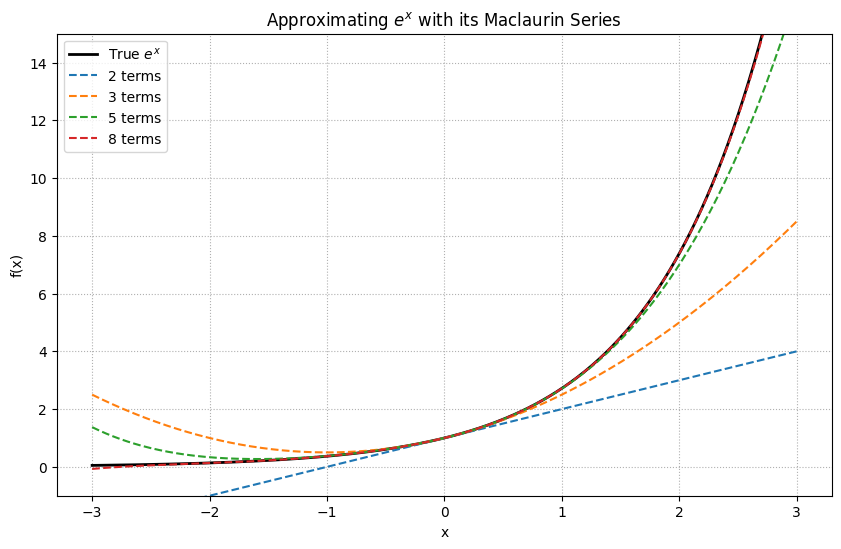

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

def taylor_exp_naive(x, n_terms):
    """A naive computation of e^x using its Taylor series up to n_terms."""
    # Start with the first term (k=0), which is 1
    approximation = 1.0
    
    # Add terms from k=1 up to n_terms-1
    for k in range(1, n_terms):
        approximation += (x**k) / math.factorial(k)
        
    return approximation

# --- Visualization ---
x_vals = np.linspace(-3, 3, 400)
true_vals = np.exp(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, true_vals, label='True $e^x$', color='black', linewidth=2)

# Plot approximations with different numbers of terms
for n in [2, 3, 5, 8]:
    approx_vals = [taylor_exp_naive(x, n) for x in x_vals]
    plt.plot(x_vals, approx_vals, label=f'{n} terms', linestyle='--')

plt.title('Approximating $e^x$ with its Maclaurin Series')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True, linestyle=':')
plt.ylim(-1, 15)
plt.show()

The plot shows that as we add more terms, the approximation hugs the true function curve more closely, especially for `x` values near the center (0).

## 3. The Problem with Negative Inputs: Catastrophic Cancellation

While the series formula works for all $x$, it becomes numerically unstable when $x$ is a large negative number. Let's examine the series for $e^{-20}$:
$$ e^{-20} = 1 - \frac{20}{1!} + \frac{20^2}{2!} - \frac{20^3}{3!} + \cdots = 1 - 20 + 200 - 1333.33 + \cdots $$

The true value of $e^{-20}$ is a very small positive number (approx. $2.06 \times 10^{-9}$). However, to calculate it, the series forces us to sum very large positive and negative numbers. This is a classic recipe for **catastrophic cancellation**.

When we subtract two nearly equal numbers, most of the leading, significant digits cancel out, leaving a result dominated by the less-significant digits, which are contaminated by rounding errors. This leads to a massive loss of precision.

### A Numerically Stable Alternative

A much better way to compute $e^x$ for a negative $x$ is to use the identity:
$$ e^x = \frac{1}{e^{-x}} $$

If $x$ is negative, then $y = -x$ is positive. We can compute the Taylor series for $e^y$ (which is stable as it only involves adding positive terms) and then take its reciprocal.

Let's compare these two methods.

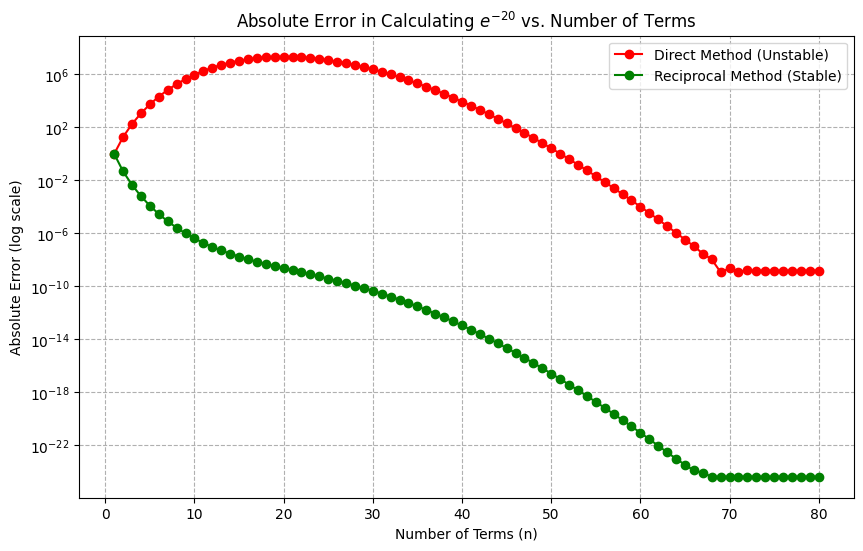

In [2]:
def compare_negative_x_methods(x, n_terms_max):
    """Compares the direct (unstable) vs. reciprocal (stable) methods for e^x where x < 0."""
    if x >= 0:
        print("This function is for demonstrating issues with negative x.")
        return

    true_value = np.exp(x)
    y = -x
    
    n_values = range(1, n_terms_max + 1)
    direct_errors = []
    reciprocal_errors = []

    for n in n_values:
        # Method 1: Direct, unstable calculation
        direct_approx = taylor_exp_naive(x, n)
        direct_errors.append(abs(direct_approx - true_value))
        
        # Method 2: Stable, reciprocal calculation
        reciprocal_approx = 1 / taylor_exp_naive(y, n)
        reciprocal_errors.append(abs(reciprocal_approx - true_value))
        
    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    plt.semilogy(n_values, direct_errors, 'r-o', label='Direct Method (Unstable)')
    plt.semilogy(n_values, reciprocal_errors, 'g-o', label='Reciprocal Method (Stable)')
    
    plt.title(f'Absolute Error in Calculating $e^{{{x}}}$ vs. Number of Terms')
    plt.xlabel('Number of Terms (n)')
    plt.ylabel('Absolute Error (log scale)')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

# Test with a large negative number
compare_negative_x_methods(x=-20, n_terms_max=80)

**Analysis of the Plot:**

- The **stable (reciprocal) method** converges beautifully. As we add more terms, the error consistently decreases, approaching the limits of machine precision.
- The **unstable (direct) method** is a complete disaster. The error initially decreases, but as the terms in the series grow larger, catastrophic cancellation kicks in, and the error explodes. The final result is meaningless.

This powerfully illustrates why the choice of algorithm is just as important as the mathematical formula itself.

## 4. Improving Efficiency and Avoiding Overflow

Our `taylor_exp_naive` function is clear, but it's very inefficient for two reasons:
1.  **Repeated Calculations**: In each loop, we compute `x**k` and `math.factorial(k)` from scratch. This is wasteful.
2.  **Overflow Risk**: The factorial function `k!` grows incredibly fast. For even moderately large `k` (e.g., `k > 170`), `math.factorial(k)` will cause an overflow error, crashing the program.

We can solve both problems by calculating each term **iteratively** based on the previous one. Notice the relationship between consecutive terms:
$$ \text{Term}_k = \frac{x^k}{k!} = \frac{x^{k-1}}{(k-1)!} \cdot \frac{x}{k} = \text{Term}_{k-1} \cdot \frac{x}{k} $$

This allows us to compute each new term with just one multiplication and one division, completely avoiding large intermediate numbers from factorials and powers.

In [3]:
def taylor_exp_efficient(x, n_terms):
    """An efficient and stable computation of e^x using its Taylor series."""
    current_term = 1.0
    approximation = 1.0
    
    for k in range(1, n_terms):
        # Calculate the next term from the previous one
        current_term *= x / k
        approximation += current_term
        
    return approximation

# Let's quickly verify it gives the same results as the naive version
x_val = 5
n_val = 15
print(f"Naive method result:    {taylor_exp_naive(x_val, n_val)}")
print(f"Efficient method result:  {taylor_exp_efficient(x_val, n_val)}")
print(f"np.exp result:          {np.exp(x_val)}")

Naive method result:    148.37958007973663
Efficient method result:  148.37958007973666
np.exp result:          148.4131591025766


## 5. Practical Implementation: Using a Stopping Criterion

In a real application, we don't want to specify the number of terms `n` manually. A better approach is to continue adding terms until they become so small that they no longer contribute meaningfully to the sum. This is known as a **stopping criterion**.

We can stop the loop when the absolute value of the `current_term` falls below a certain tolerance (e.g., `1e-9`).

In [6]:
def robust_exp_taylor(x, tolerance=1e-9):
    """
    A robust function to calculate e^x using the most stable and efficient methods.
    - Handles negative x using the reciprocal method.
    - Uses an efficient iterative term calculation.
    - Stops when the terms become smaller than a specified tolerance.
    """
    # Use the stable reciprocal method for negative x
    if x < 0:
        approx, k = robust_exp_taylor(-x, tolerance)
        return 1 / approx, k

    current_term = 1.0
    approximation = 1.0
    k = 1
    
    while abs(current_term) > tolerance:
        current_term *= x / k
        approximation += current_term
        k += 1
        # Safety break to prevent infinite loops, though unlikely here
        if k > 1000: 
            break
            
    return approximation, k

# --- Testing the final function ---
test_values = [1, 5, 20, -1, -5, -20]

print(f"{'x':>5} | {'Taylor Approx':>20} | {'True Value':>20} | {'Terms Used':>12}")
print("-"*65)

for val in test_values:
    approx, terms = robust_exp_taylor(val)
    true_val = np.exp(val)
    print(f"{val:>5} | {approx:>20.15f} | {true_val:>20.15f} | {terms:>12}")

    x |        Taylor Approx |           True Value |   Terms Used
-----------------------------------------------------------------
    1 |    2.718281828446759 |    2.718281828459045 |           14
    5 |  148.413159102429177 |  148.413159102576600 |           28
   20 | 485165195.409790456295013 | 485165195.409790277481079 |           71
   -1 |    0.367879441173105 |    0.367879441171442 |           14
   -5 |    0.006737946999092 |    0.006737946999085 |           28
  -20 |    0.000000002061154 |    0.000000002061154 |           71


## 6. Conclusion

This exploration of the Taylor series for $e^x$ has provided several crucial insights into numerical methods:

1.  **Numerical Stability is Paramount**: A mathematically correct formula can produce completely wrong results if it is not implemented in a stable way. Rearranging the problem (like using $1/e^{-x}$) is a common and powerful technique.
2.  **Computational Efficiency Matters**: Re-calculating values like factorials is slow and risky. Iterative methods that build upon previous results are often far superior.
3.  **Stopping Criteria are Practical**: In practice, iterative algorithms are terminated based on a tolerance, not a fixed number of steps, ensuring that just enough work is done to achieve the desired accuracy.